In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from itertools import combinations

In [2]:
def preprocess_data(df, target_col=None, le_dict=None, scaler=None):
    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Encode categorical features
    if le_dict is None:  # first dataset → fit new encoders
        le_dict = {}
        for col in df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            le_dict[col] = le
    else:  # second dataset → transform with existing encoders
        for col in df.select_dtypes(include=['object']).columns:
            if col in le_dict:
                df[col] = le_dict[col].transform(df[col])
            else:
                raise ValueError(f"Unexpected categorical column: {col}")

    # Separate features and target
    if target_col and target_col in df.columns:
        X = df.drop(columns=[target_col], axis=1)
        y = df[[target_col]]
    else:
        X = df.copy()
        y = None

    # Standardize numerical features (exclude target if present)
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    if scaler is None:  # first dataset → fit scaler
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:  # second dataset → use existing scaler
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    return X, y, le_dict, scaler


In [3]:
adult = pd.read_csv('project_adult.csv')
validation_inputs = pd.read_csv('project_validation_inputs.csv')
print(adult.columns)
print(validation_inputs.columns)

Index(['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education',
       'education-num', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country', 'income'],
      dtype='object')
Index(['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education',
       'education-num', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country'],
      dtype='object')


In [4]:
X_train, y_train, le_dict, scaler = preprocess_data(adult, target_col = "income")
X_test, y2, _, _ = preprocess_data(validation_inputs, target_col = "income", le_dict=le_dict, scaler=scaler)
print(y2)

None


In [5]:
# Train with linear kernel
model_rbf = SVC(kernel='rbf', C=1)
model_rbf.fit(X_train, y_train.values.ravel())

SVC(C=1)

In [6]:
y_pred = model_rbf.predict(X_test)

In [ ]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.
# Code modified from in-class assignment

# Define the parameter grid to search over.
param_grid = {
    'C': [0.01, 1, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 1, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [8]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8481


In [9]:
y_val_predicted = best_model.predict(X_test)
validation_inputs["predicted_income"] = y_val_predicted
print(validation_inputs["predicted_income"].head())


0    0
1    0
2    1
3    0
4    0
Name: predicted_income, dtype: int64


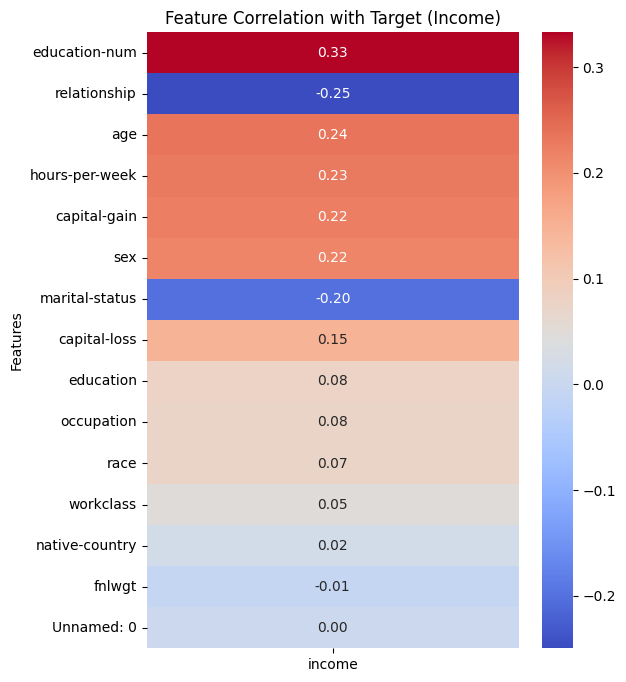

In [10]:
# Combine features and target
df_corr = pd.concat([X_train, y_train], axis=1)

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Extract correlation of each feature with the target
feature_corr = corr_matrix[["income"]].drop("income")  # drop the target itself

# Sort features by absolute correlation (optional, makes it easier to read)
feature_corr_sorted = feature_corr.reindex(feature_corr["income"].abs().sort_values(ascending=False).index)

# Plot heatmap
plt.figure(figsize=(6, 8))  # adjust figure size for readability
sns.heatmap(feature_corr_sorted, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Feature Correlation with Target (Income)")
plt.ylabel("Features")
plt.show()


In [18]:
def plot_svm_edu_relationship(grid_search, X, y):
    """
    Plots the decision boundary for the best SVM model (from GridSearchCV)
    using only 'education-num' and 'relationship'.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Ensure y is a Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If y is a DataFrame, it must have a single column.")
        y_series = y.iloc[:, 0]
    else:
        y_series = pd.Series(y).ravel()

    # Encode target if needed
    if y_series.dtype == 'object':
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    # Select only the two features
    features = ["education-num", "relationship"]
    X_pair = X[features].copy()

    # Retrain a new SVM on just these two features for visualization
    from sklearn.svm import SVC
    plot_model = SVC(
        kernel=best_params.get('kernel', 'rbf'),
        C=best_params.get('C', 1.0),
        gamma=best_params.get('gamma', 'auto'),
        probability=False
    )
    plot_model.fit(X_pair.values, y_encoded)

    # Create meshgrid
    x_min, x_max = X_pair["education-num"].min() - 1, X_pair["education-num"].max() + 1
    y_min, y_max = X_pair["relationship"].min() - 1, X_pair["relationship"].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on meshgrid
    Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pair["education-num"], X_pair["relationship"], c=y_encoded, cmap=plt.cm.coolwarm,
                s=50, edgecolor='k')
    plt.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', label='Support Vectors')
    plt.xlabel("education-num")
    plt.ylabel("relationship")
    plt.title(f"SVM Decision Boundary (Best Model)\nKernel: {best_params.get('kernel')}, C: {best_params.get('C')}")
    plt.legend()
    plt.show()


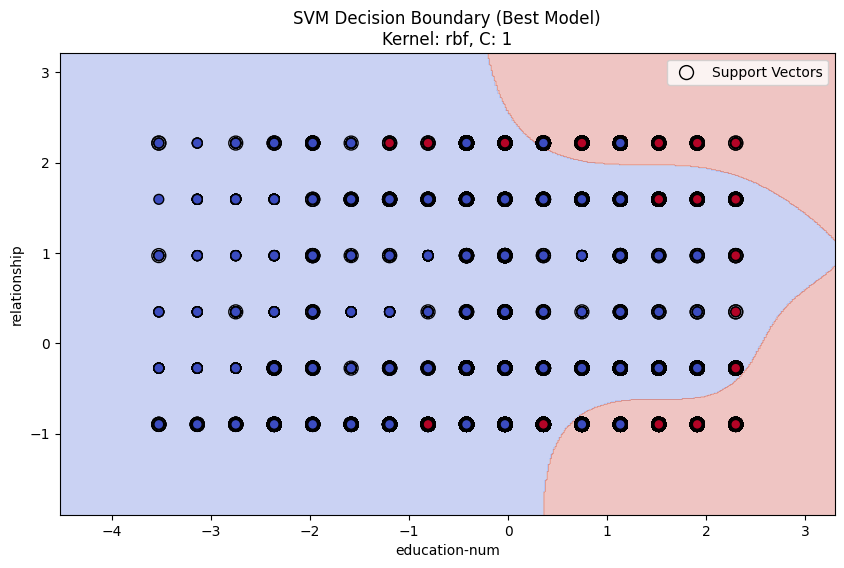

In [19]:
plot_svm_edu_relationship(grid_search, X_train, y_train)

In [ ]:
def plot_svm_age_capitalgain(grid_search, X, y):
    """
    Plots the decision boundary for the best SVM model (from GridSearchCV)
    using only 'age' and 'capital-gain'.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Ensure y is a Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If y is a DataFrame, it must have a single column.")
        y_series = y.iloc[:, 0]
    else:
        y_series = pd.Series(y).ravel()

    # Encode target if needed
    if y_series.dtype == 'object':
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = y_series.values

    # Select only the two features
    features = ["age", "capital-gain"]
    X_pair = X[features].copy()

    # Retrain a new SVM on just these two features for visualization
    from sklearn.svm import SVC
    plot_model = SVC(
        kernel=best_params.get('kernel', 'rbf'),
        C=best_params.get('C', 1.0),
        gamma=best_params.get('gamma', 'auto'),
        probability=False
    )
    plot_model.fit(X_pair.values, y_encoded)

    # Create meshgrid
    x_min, x_max = X_pair["age"].min() - 1, X_pair["age"].max() + 1
    y_min, y_max = X_pair["capital-gain"].min() - 1, X_pair["capital-gain"].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on meshgrid
    Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pair["age"], X_pair["capital-gain"], c=y_encoded, cmap=plt.cm.coolwarm,
                s=50, edgecolor='k')
    plt.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', label='Support Vectors')
    plt.xlabel("Age")
    plt.ylabel("Capital Gain")
    plt.title(f"SVM Decision Boundary (Best Model)\nKernel: {best_params.get('kernel')}, C: {best_params.get('C')}")
    plt.legend()
    plt.show()


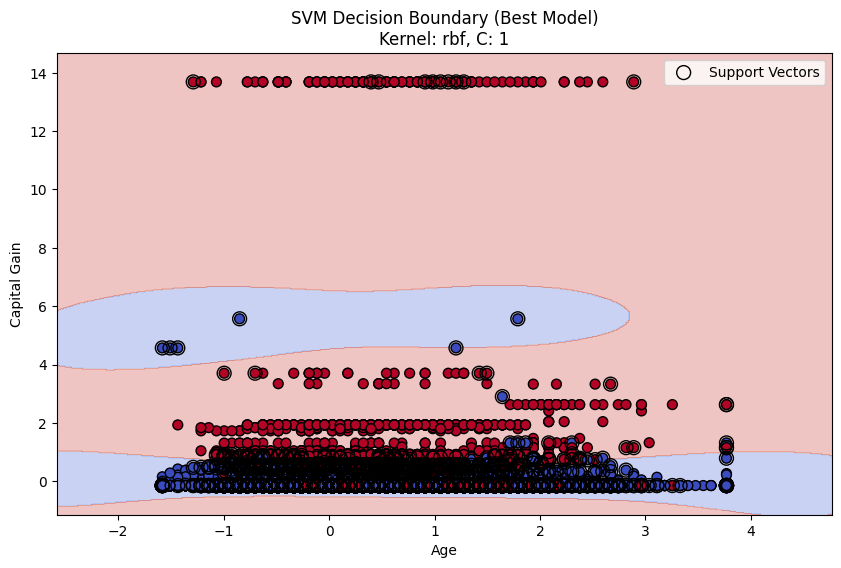

In [15]:
plot_svm_age_capitalgain(grid_search, X_train, y_train)

In [ ]:
def svm_c_test(X, y):
    """
    Trains SVM models with different C values
    and plots their accuracies.
    """
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Candidate C values
    C_values = [0.01, 1, 100]
    train_accuracies = []
    test_accuracies = []

    for C in C_values:
        # Train SVM with RBF kernel (default)
        svm = SVC(C=C, kernel='rbf', gamma='scale')
        svm.fit(X_train, y_train)

        # Evaluate
        train_acc = accuracy_score(y_train, svm.predict(X_train))
        test_acc = accuracy_score(y_test, svm.predict(X_test))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"C={C}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(C_values, train_accuracies, marker='o', linestyle='--', label="Train Accuracy")
    plt.plot(C_values, test_accuracies, marker='s', linestyle='-', label="Test Accuracy")
    plt.xscale("log")
    plt.xlabel("C (Inverse Regularization Strength)")
    plt.ylabel("Accuracy")
    plt.title("Effect of C on SVM Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C=0.01: Train Accuracy = 0.7920, Test Accuracy = 0.7994


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C=1: Train Accuracy = 0.8566, Test Accuracy = 0.8514


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C=100: Train Accuracy = 0.9061, Test Accuracy = 0.8390


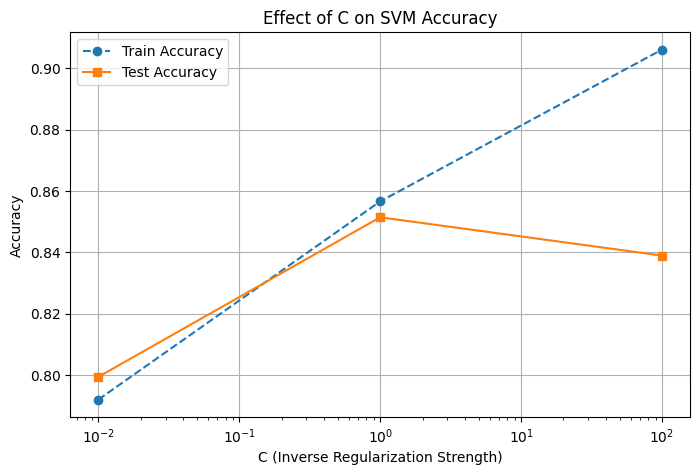

In [17]:
svm_c_test(X_train, y_train)
